# Preprocess PLIER pathway data and map gene symbols to Entrez IDs

In [1]:
import os
import urllib.request
import pandas as pd

import config as cfg
from scripts.symbol_to_entrez_id import symbol_to_entrez_id

## Get pathway .Rdata files from PLIER Github repo

#### These are originally derived from MSigDB.

In [2]:
if not os.path.exists(cfg.pathway_data):
    os.makedirs(cfg.pathway_data)
canonical_pathways = os.path.join(cfg.pathway_data, 'canonical_pathways.tsv')
oncogenic_pathways = os.path.join(cfg.pathway_data, 'oncogenic_pathways.tsv')
if (not os.path.exists(canonical_pathways)) or (not os.path.exists(oncogenic_pathways)):
    import subprocess
    r_script = os.path.join(os.getcwd(), 'scripts', 'get_plier_pathway_data.R')
    args = ['Rscript', r_script]
    subprocess.check_call(args)

In [3]:
canonical_df = pd.read_csv(canonical_pathways, sep='\t')
oncogenic_df = pd.read_csv(oncogenic_pathways, sep='\t')
first_cols = canonical_df.columns.values[0:5]
canonical_df.loc[:, first_cols].head()

,PID_CASPASE_PATHWAY,PID_P38ALPHABETADOWNSTREAMPATHWAY,REACTOME_APC_C_CDC20_MEDIATED_DEGRADATION_OF_MITOTIC_PROTEINS,REACTOME_REGULATION_OF_APOPTOSIS,REACTOME_IRON_UPTAKE_AND_TRANSPORT
UBE2Q1,0,0,0,0,0
UBE2Q2,0,0,0,0,0
PMM2,0,0,0,0,0
PMM1,0,0,0,0,0
NCBP1,0,0,0,0,0


In [4]:
first_cols = oncogenic_df.columns.values[0:5]
oncogenic_df.loc[:, first_cols].head()

,MYC_UP.V1_UP,PDGF_UP.V1_UP,BMI1_DN.V1_DN,SIRNA_EIF4GI_UP,CYCLIN_D1_KE_.V1_UP
RNF14,0,1,0,0,0
DUOXA1,0,0,0,0,0
RNF17,0,0,0,0,0
RNF10,0,0,0,0,0
RNF11,0,0,0,0,0


## Map canonical pathway data

In [5]:
gene_symbols = canonical_df.index.values
canonical_map = symbol_to_entrez_id(gene_symbols, verbose=True)
for i, (k, v) in enumerate(canonical_map.items()):
    if i >= 5: break
    print('{}\t{}'.format(k, v))

Querying for exact matches:
-- Matched 5832 of 6023 genes
Trying to manually map unmapped genes:
-- Matched 3 of 191 genes
Querying MyGene for aliases of 188 unmatched genes:
-- Found aliases for 187 of 188 genes
Querying for alias entrez IDs:
-- Matched 187 of 187 genes
RESULTS: matched 6022 of 6023 genes (0 duplicate Entrez IDs)
ADA	100
CDH2	1000
AKT3	10000
MED6	10001
ACOT8	10005


In [6]:
canonical_df = canonical_df.assign(eid=canonical_df.index.map(canonical_map))
unmapped_genes = canonical_df[canonical_df['eid'] == 'N/A']
canonical_df = (
    canonical_df.dropna(subset=['eid'])
    .set_index('eid')
)
del canonical_df.index.name
canonical_df.iloc[:5, :5]

,PID_CASPASE_PATHWAY,PID_P38ALPHABETADOWNSTREAMPATHWAY,REACTOME_APC_C_CDC20_MEDIATED_DEGRADATION_OF_MITOTIC_PROTEINS,REACTOME_REGULATION_OF_APOPTOSIS,REACTOME_IRON_UPTAKE_AND_TRANSPORT
55585,0,0,0,0,0
92912,0,0,0,0,0
5373,0,0,0,0,0
5372,0,0,0,0,0
4686,0,0,0,0,0


In [7]:
print('Number of gene symbols not mapped: {} ({})'.format(
    len(unmapped_genes), ' '.join(unmapped_genes.index.values)))

Number of gene symbols not mapped: 1 (CD97)


In [8]:
canonical_df.to_csv(os.path.join(cfg.pathway_data, 'canonical_mapped.tsv'),
                    sep='\t')

## Map oncogenic pathway data

In [9]:
gene_symbols = oncogenic_df.index.values
oncogenic_map = symbol_to_entrez_id(gene_symbols, verbose=True)
for i, (k, v) in enumerate(canonical_map.items()):
    if i >= 5: break
    print('{}\t{}'.format(k, v))

Querying for exact matches:
-- Matched 10288 of 11250 genes
Trying to manually map unmapped genes:
-- Matched 162 of 962 genes
Querying MyGene for aliases of 800 unmatched genes:
-- Found aliases for 707 of 800 genes
Querying for alias entrez IDs:
-- Matched 707 of 707 genes
RESULTS: matched 11157 of 11250 genes (1 duplicate Entrez IDs)
ADA	100
CDH2	1000
AKT3	10000
MED6	10001
ACOT8	10005


In [10]:
oncogenic_df['eid'] = [oncogenic_map[g] for g in oncogenic_df.index.values]
oncogenic_df = oncogenic_df[oncogenic_df['eid'] != 'N/A']
oncogenic_df.set_index('eid', inplace=True)
del oncogenic_df.index.name
first_cols = oncogenic_df.columns.values[0:5]
oncogenic_df.loc[:, first_cols].head()

,MYC_UP.V1_UP,PDGF_UP.V1_UP,BMI1_DN.V1_DN,SIRNA_EIF4GI_UP,CYCLIN_D1_KE_.V1_UP
9604,0,1,0,0,0
90527,0,0,0,0,0
56163,0,0,0,0,0
9921,0,0,0,0,0
26994,0,0,0,0,0


In [11]:
oncogenic_df.to_csv(os.path.join(cfg.pathway_data, 'oncogenic_mapped.tsv'),
                    sep='\t')

## Generate randomized pathway data from set of all TCGA genes

In [53]:
train_df = pd.read_csv(os.path.join(cfg.data_dir, 'train_tcga_expression_matrix_processed.tsv.gz'),
                       sep='\t', index_col=0)
test_df = pd.read_csv(os.path.join(cfg.data_dir, 'test_tcga_expression_matrix_processed.tsv.gz'),
                      sep='\t', index_col=0)
print(train_df.shape)
print(test_df.shape)

(9954, 16148)
(1106, 16148)


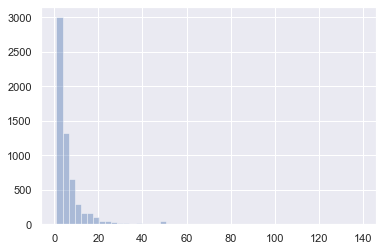

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  54,  55,
        56,  57,  60,  61,  62,  63,  64,  65,  66,  68,  71,  72,  73,
        76,  77,  80,  82,  83,  86,  88, 102, 103, 107, 110, 111, 122,
       136, 138, 139]), array([1346,  947,  707,  596,  426,  305,  279,  196,  176,  118,   90,
         86,   78,   89,   64,   52,   45,   35,   33,   37,   14,   23,
         13,   18,   30,    9,   11,    7,    6,    5,    5,   10,   13,
          3,    5,    9,    7,    5,    6,    3,    2,    4,    1,    4,
          7,   34,    6,    4,    3,    2,    4,    1,    3,    2,    2,
          2,    3,    1,    1,    1,    1,    2,    1,    2,    1,    2,
          2,    1,    1,    3,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    2,    1]))

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(1)
sns.set()
sns.distplot(canonical_df.sum(axis=1).values, kde=False)
plt.show()
print(np.unique(canonical_df.sum(axis=1).values, return_counts=True))

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 41, 42, 57]), array([731, 648, 554, 439, 393, 361, 264, 241, 223, 167, 138, 119, 126,
       102,  76,  61,  59,  43,  38,  27,  28,  20,  25,  18,  21,  12,
        12,   8,  10,   5,   6,   1,   4,   1,   5,   3,   4,   2,   2,
         2,   1]))


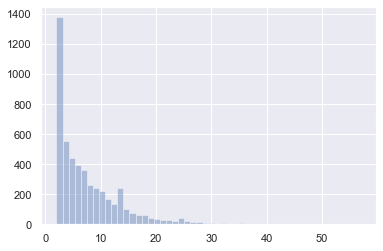

In [55]:
num_pws = 5000
num_genes = train_df.shape[1]
sim_counts = np.random.geometric(p=0.15, size=num_pws)+1
sns.distplot(sim_counts, kde=False)
print(np.unique(sim_counts, return_counts=True))

In [56]:
sim_pws = np.zeros((num_pws, num_genes), dtype=int)
for i, pw_count in enumerate(sim_counts):
    sim_pw = np.zeros((num_genes,), dtype=int)
    sim_pw[0:pw_count] = 1
    np.random.shuffle(sim_pw)
    sim_pws[i, :] = sim_pw
print(sim_pws[1:10, 1:10])
print(np.sum(sim_pws, axis=1))

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
[ 5  9  2 ...  4 31  3]


In [57]:
pw_names = ['PW{}'.format(i) for i in range(1, num_pws+1)]
sim_df = pd.DataFrame(data=sim_pws, index=pw_names, columns=train_df.columns).T
print(sim_df.head())

       PW1  PW2  PW3  PW4  PW5  PW6  PW7  PW8  PW9  PW10  ...  PW4991  PW4992  \
1        0    0    0    0    0    0    0    0    0     0  ...       0       0   
10       0    0    0    0    0    0    0    0    0     0  ...       0       0   
100      0    0    0    0    0    0    0    0    0     0  ...       0       0   
1000     0    0    0    0    0    0    0    0    0     0  ...       0       0   
10000    0    0    0    0    0    0    0    0    0     0  ...       0       0   

       PW4993  PW4994  PW4995  PW4996  PW4997  PW4998  PW4999  PW5000  
1           0       0       0       0       0       0       0       0  
10          0       0       0       0       0       0       0       0  
100         0       0       0       0       0       0       0       0  
1000        0       0       0       0       0       0       0       0  
10000       0       0       0       0       0       0       0       0  

[5 rows x 5000 columns]


In [ ]:
sim_df.to_csv(os.path.join(cfg.pathway_data, 'randomized_pathways.tsv'),
              sep='\t')